In [2]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

### Using a NN to solve a simple ODE
Goal is to construct a model which can produce approximate solutions for the following ODE:
$$
\begin{aligned}
    &y'' = f(x, y(x)), \quad 0 < x < 1, \\
    &y(0) = y_0, \\
    &y(1) = y_1.
\end{aligned}
$$

We can define the following loss function:

$ \mathcal{L} = \sum\limits_{k}^{} (\hat{y}''(x_k) - f(x_k, \hat{y}(x_k)))^2 + \gamma(\hat{y}(0)-y_0)^2 + \gamma (\hat{y}|(1) - y_1)^2$

Let's do this for the following system:

\begin{aligned}
    &y'' = 2, \quad 0 < x < 1,\\
    &y(0) = 1, \\
    &y(1) = 1.
\end{aligned}

This has the exact solution $y(x) = 1 + x(1-x)$

Epoch: 0, Loss: 6.207911014556885
Epoch: 500, Loss: 0.0035644089803099632
Epoch: 1000, Loss: 0.0018637216417118907
Epoch: 1500, Loss: 0.0004661782004404813
Epoch: 2000, Loss: 0.00010021314665209502
Epoch: 2500, Loss: 7.08995430613868e-05
Epoch: 3000, Loss: 5.644563498208299e-05
Epoch: 3500, Loss: 4.288410855224356e-05
Epoch: 4000, Loss: 3.0333410904859193e-05
Epoch: 4500, Loss: 1.9664408682729118e-05


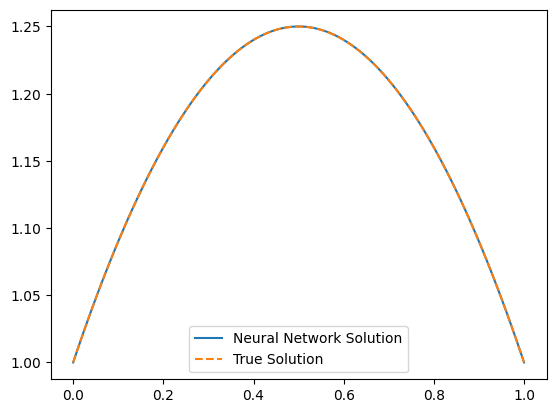

In [3]:
# 1. Setup the model
class ODE_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)
    
# 2. Setup the loss function
def compute_loss(model, x_interior, x_boundary):
    x_interior.requires_grad = True

    y_pred = model(x_interior)

    # Compute gradients
    dy_dx = torch.autograd.grad(y_pred, x_interior, grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_interior, grad_outputs=torch.ones_like(dy_dx),
                                  create_graph=True)[0]
    
    # Compute boundary values
    y_b0 = model(x_boundary[0])
    y_b1 = model(x_boundary[1])
    

    # Construct Loss
    gamma1 = 1
    gamma2 = 2
    loss = torch.mean((-d2y_dx2 - 2)**2) + (y_b0 - 1)**2 + (y_b1 - 1)**2 # pde loss + boundary loss
    
    return loss


# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ODE_nn().to(device)
lr = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

# Training data: sample points in (0, 1)
x_interior = torch.linspace(0.01, 0.99, 100).view(-1, 1).to(device)
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32).to(device)

# Training loop 
for epoch in range(5000):
    optimiser.zero_grad()
    loss = compute_loss(model, x_interior, x_boundary)
    loss.backward()
    optimiser.step()

    if epoch %500 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")


# Plot the results
x_test = torch.linspace(0, 1, 100).view(-1, 1).to(device)
y_pred = model(x_test).detach().cpu().numpy()

# True solution y(x) = x^2 + C_1 x + C_2
C1, C2 = 0, 1  # From boundary conditions
y_true = lambda x: 1 + x * (1-x)

plt.plot(x_test.cpu().numpy(), y_pred, label="Neural Network Solution")
plt.plot(x_test.cpu().numpy(), y_true(x_test.cpu().numpy()), "--", label="True Solution")
plt.legend()
plt.show()


Ok beautiful. Now to consider a modifiied loss function to verify that this results in the same solution.

We can instead do the following substitution: \
$ \bar{y}(x) = \hat{y}(x) + (1-x)(y_0 - \hat{y}(0) + x(y_1-\hat{y}(1)))$

This has the effect when evaluating at the boundary that:

$
\begin{aligned}
    &\bar{y}(0) = \hat{y}(0) + y_0 - \hat{y}(0) = y_0 \\
    &\bar{y}(1) = \hat{y}(1) + y_1 - \hat{y}(1) = y_1
\end{aligned}
$

So $\bar{y}(x)$ automatically satisfies the BCs and we can use the loss function: \
$ \bar{\mathcal{L}} = \sum\limits_{k}^{} (\bar{y}''(x_k) - f(x_k, \hat{y}(x_k)))^2$


Now to try and instead implement this then. So I need to map the outputs from my neural net now to what would have been $\hat{y}$.

Epoch: 0, Loss: 4.101503372192383
Epoch: 500, Loss: 0.0005846928688697517
Epoch: 1000, Loss: 7.415177969960496e-05
Epoch: 1500, Loss: 9.756638974067755e-06
Epoch: 2000, Loss: 5.223192147241207e-06
Epoch: 2500, Loss: 5.000187229597941e-06
Epoch: 3000, Loss: 4.861209617956774e-06
Epoch: 3500, Loss: 4.687799446401186e-06
Epoch: 4000, Loss: 4.477317816053983e-06
Epoch: 4500, Loss: 4.232203536957968e-06


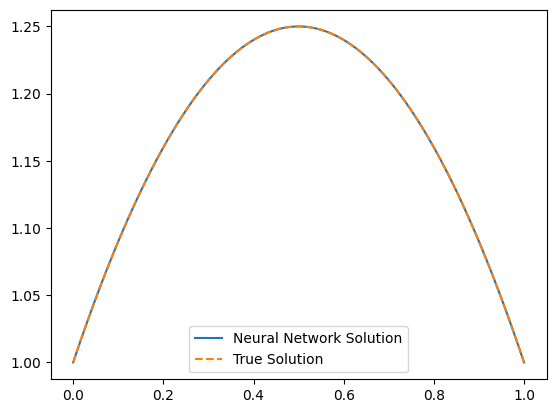

In [4]:

def transformed_solution(model, x, x_boundary):
    y_hat = model(x)
    y_hat_0 = model(x_boundary[0])
    y_hat_1 = model(x_boundary[1])
    y_bc = (1 - x) * (1 - y_hat_0) + x * (1 - y_hat_1)  # Imposing BCs
    return y_hat + y_bc


def compute_loss_modified(model, x_interior, x_boundary):
    x_interior.requires_grad = True

    y_bar = transformed_solution(model, x_interior, x_boundary)

    
    dy_dx = torch.autograd.grad(y_bar, x_interior, grad_outputs=torch.ones_like(y_bar),
                                create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_interior, grad_outputs=torch.ones_like(dy_dx),
                                  create_graph=True)[0]
    
    # Loss based only on residual
    loss = torch.mean((-d2y_dx2 - 2)**2)
    
    return loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ODE_nn().to(device)
lr = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

# Training data: sample points in (0, 1)
x_interior = torch.linspace(0.01, 0.99, 100).view(-1, 1).to(device)
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32).to(device)

# Training loop 
for epoch in range(5000):
    optimiser.zero_grad()
    loss = compute_loss_modified(model, x_interior, x_boundary)
    loss.backward()
    optimiser.step()

    if epoch % 500 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Plot the results
x_test = torch.linspace(0, 1, 100).view(-1, 1).to(device)
y_pred = transformed_solution(model, x_test, x_boundary).detach().cpu().numpy()

# True solution y(x) = 1 + x(1 - x)
y_true = lambda x: 1 + x * (1 - x)

plt.plot(x_test.cpu().numpy(), y_pred, label="Neural Network Solution")
plt.plot(x_test.cpu().numpy(), y_true(x_test.cpu().numpy()), "--", label="True Solution")
plt.legend()
plt.show()


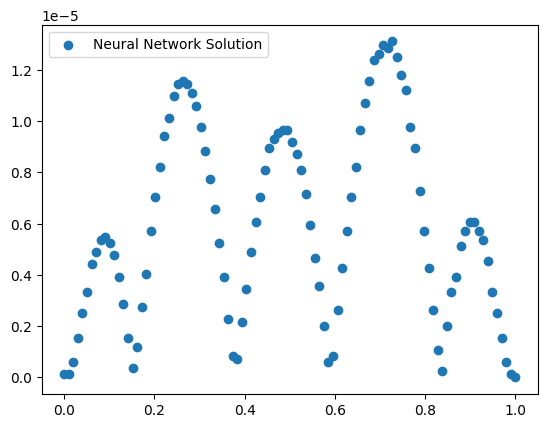

In [5]:
plt.scatter(x_test.cpu().numpy(), abs(y_true(x_test.cpu().numpy())- y_pred), label="Neural Network Solution")
# plt.plot(x_test.cpu().numpy(), y_true(x_test.cpu().numpy()), "--", label="True Solution")
plt.legend()
plt.show()